In [8]:
import sys
import numpy as np
import os

import mpld3
import matplotlib.pyplot as plt

In [9]:
# Constants
CONTROL1_FILE_PATH = "../output/Analysis_control_1.txt"
CONTROL2_FILE_PATH = "../output/Analysis_control_2.txt"
CONTROL3_FILE_PATH = "../output/Analysis_control_3.txt"
CONTROL4_FILE_PATH = "../output/Analysis_control_4.txt"

ZTHRESH_FILE_PATH = "../output/Analysis_zthresh.txt"
ZYTHRESH_FILE_PATH = "../output/Analysis_zythresh.txt"
ZYXTHRESH_FILE_PATH = "../output/Analysis_zyxthresh.txt"

In [10]:
class TagDetectionStatistics:
    ORIGINAL_CLUSTER_SIZE_IDX     = 13
    CLUSTERS_REMOVED_BY_POINT_IDX = 14
    REMAINING_CLUSTERS_IDX        = 15
    
    CLUSTER_IDX_IN_PC_IDX     = 0

    class Data:
        def __init__(self):
            # Original cluster size with thresholding
            self.total_num_clusters   = []
            # The id of the cluster per payload
            # Will be 1 for every line if only one cluster / payload
            self.cluster_pc_ids       = [] 
            # Number of clusters removed by point check
            self.pt_rm_clusters       = []
            # Remainign clusters in point cloud after all checks
            self.clusters_in_pc       = []

    def __init__(self):
        self.original_cluster_size = []
        self.cluster_idx_in_pc     = []
        self.not_met_point_thresh  = []
        self.remaining_clusters    = []

    def convertToNumpy(self):
        data = TagDetectionStatistics.Data()
        data.total_num_clusters   = np.array(self.original_cluster_size).astype(np.int)
        data.cluster_pc_ids = np.array(self.cluster_idx_in_pc).astype(np.int)
        data.pt_rm_clusters = np.array(self.not_met_point_thresh).astype(np.int)
        data.clusters_in_pc = np.array(self.remaining_clusters).astype(np.int) 

        self.reportWarnings(data)
        
        return data
    
    def reportWarnings(self, data):
        if not self.oneClusterPerPCCheck(data):
            print("Warning, some payloads have more than 1 cluster!")
    
    def oneClusterPerPCCheck(self, data):
        return np.all(data.clusters_in_pc == 1)

In [11]:
def readStatisticsFromFile(filepath):

    stats = TagDetectionStatistics()

    with open(filepath) as fp:
        for line in fp:
            line_split = line.split(',')
            
            getOriginalClusterSize(line_split, stats)
            getClusterIdxInPC(line_split, stats)
            getNumClustersRemovedByPointThreshold(line_split, stats)
            getRemainingClustersForPointCloud(line_split, stats)

    return stats

In [12]:
def getOriginalClusterSize(line, stats):
    stats.original_cluster_size.append(
        line[TagDetectionStatistics.ORIGINAL_CLUSTER_SIZE_IDX]
    )

def getClusterIdxInPC(line, stats):
    stats.cluster_idx_in_pc.append(
        line[TagDetectionStatistics.CLUSTER_IDX_IN_PC_IDX]
    )
    
def getNumClustersRemovedByPointThreshold(line, stats):
    stats.not_met_point_thresh.append(
        line[TagDetectionStatistics.CLUSTERS_REMOVED_BY_POINT_IDX]
    )
    
def getRemainingClustersForPointCloud(line, stats):
    stats.remaining_clusters.append(
        line[TagDetectionStatistics.REMAINING_CLUSTERS_IDX]
    )

In [13]:
# Get data from analysis file
stats_ctrl1 = readStatisticsFromFile(CONTROL1_FILE_PATH)
data_ctrl1  = stats_ctrl1.convertToNumpy()

stats_ctrl2 = readStatisticsFromFile(CONTROL2_FILE_PATH)
data_ctrl2  = stats_ctrl2.convertToNumpy()

stats_ctrl3 = readStatisticsFromFile(CONTROL3_FILE_PATH)
data_ctrl3  = stats_ctrl3.convertToNumpy()

stats_ctrl4 = readStatisticsFromFile(CONTROL4_FILE_PATH)
data_ctrl4  = stats_ctrl4.convertToNumpy()

stats_zthr = readStatisticsFromFile(ZTHRESH_FILE_PATH)
data_zthr  = stats_zthr.convertToNumpy()

stats_zythr = readStatisticsFromFile(ZYTHRESH_FILE_PATH)
data_zythr  = stats_zythr.convertToNumpy()

stats_zyxthr = readStatisticsFromFile(ZYXTHRESH_FILE_PATH)
data_zyxthr  = stats_zyxthr.convertToNumpy()

Warning, some payloads have more than 1 cluster!


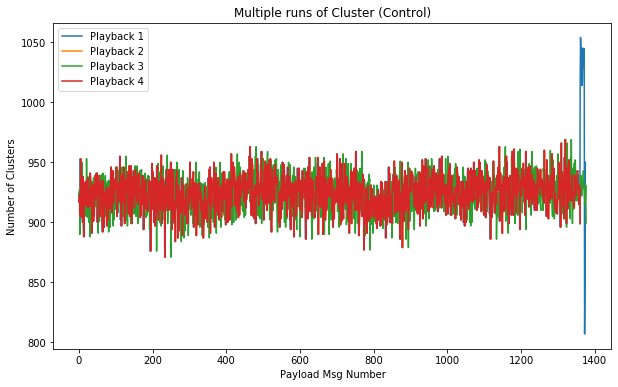

In [14]:
# Check to see that from three different runs.. the LiDAR Tag process is not deterministic
mpld3.enable_notebook()
fig = plt.gcf()
fig.set_size_inches(10,6)

plt.plot(data_ctrl1.total_num_clusters, label='Playback 1')
plt.plot(data_ctrl2.total_num_clusters, label='Playback 2')
plt.plot(data_ctrl3.total_num_clusters, label='Playback 3')
plt.plot(data_ctrl4.total_num_clusters, label='Playback 4')
plt.legend()
plt.title("Multiple runs of Cluster (Control)")
plt.xlabel("Payload Msg Number")
plt.ylabel("Number of Clusters");

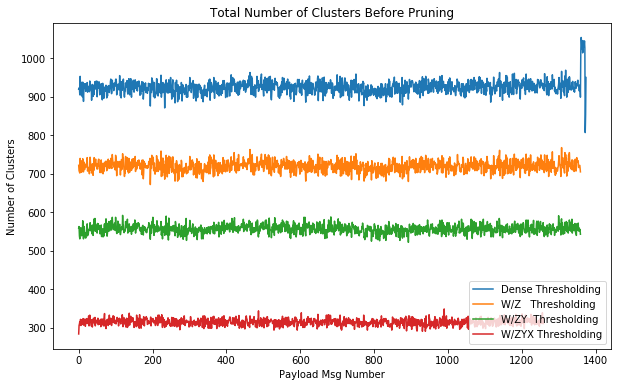

In [15]:
mpld3.enable_notebook()

fig = plt.gcf()
fig.set_size_inches(10,6)

plt.plot(data_ctrl1.total_num_clusters,  label="Dense Thresholding")
plt.plot(data_zthr.total_num_clusters,   label="W/Z   Thresholding")
plt.plot(data_zythr.total_num_clusters,  label="W/ZY  Thresholding")
plt.plot(data_zyxthr.total_num_clusters, label="W/ZYX Thresholding")
plt.title("Total Number of Clusters Before Pruning")
plt.legend()
plt.xlabel("Payload Msg Number")
plt.ylabel("Number of Clusters");

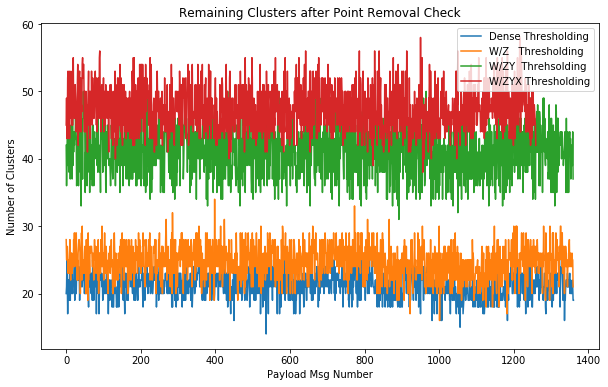

In [19]:
mpld3.enable_notebook()
remaining_clusters_ctrl   = data_ctrl1.total_num_clusters  - data_ctrl1.pt_rm_clusters
remaining_clusters_zthr   = data_zthr.total_num_clusters   - data_zthr.pt_rm_clusters
remaining_clusters_zythr  = data_zythr.total_num_clusters  - data_zythr.pt_rm_clusters
remaining_clusters_zyxthr = data_zyxthr.total_num_clusters - data_zyxthr.pt_rm_clusters

fig = plt.gcf()
fig.set_size_inches(10,6)

plt.plot(remaining_clusters_ctrl,   label="Dense Thresholding")
plt.plot(remaining_clusters_zthr,   label="W/Z   Thresholding")
plt.plot(remaining_clusters_zythr,  label="W/ZY  Threhsolding")
plt.plot(remaining_clusters_zyxthr, label="W/ZYX Thresholding")
plt.title("Remaining Clusters after Point Removal Check")
plt.legend()
plt.xlabel("Payload Msg Number")
plt.ylabel("Number of Clusters");

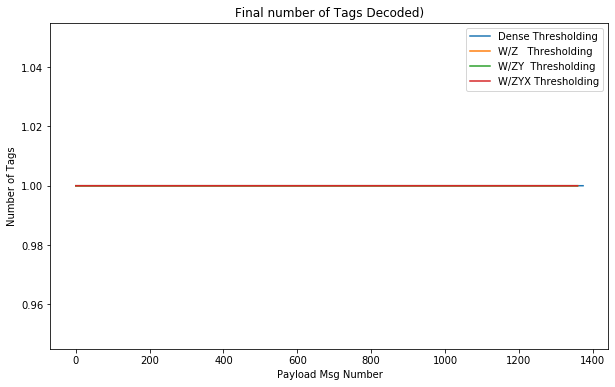

In [23]:
mpld3.enable_notebook()

fig = plt.gcf()
fig.set_size_inches(10,6)

plt.plot(data_ctrl1.clusters_in_pc, label="Dense Thresholding")
plt.plot(data_zthr.clusters_in_pc,  label="W/Z   Thresholding")
plt.plot(data_zythr.clusters_in_pc, label="W/ZY  Thresholding")
plt.plot(data_zythr.clusters_in_pc, label="W/ZYX Thresholding")
plt.title("Final number of Tags Decoded)")
plt.legend()
plt.xlabel("Payload Msg Number")
plt.ylabel("Number of Tags");

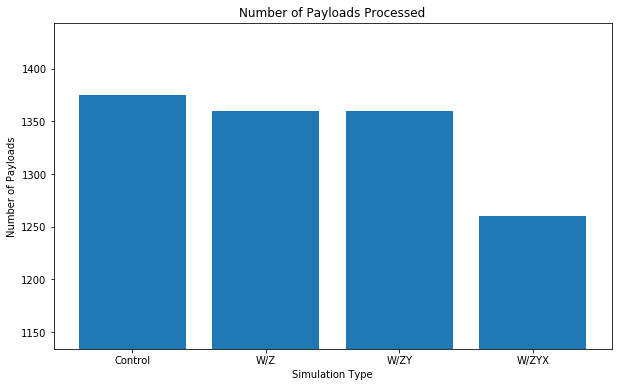

In [18]:
mpld3.enable_notebook()

num_pcs = []
num_pcs.append(data_ctrl1.clusters_in_pc.size)
num_pcs.append(data_zthr.clusters_in_pc.size)
num_pcs.append(data_zythr.clusters_in_pc.size)
num_pcs.append(data_zyxthr.clusters_in_pc.size)
num_pcs = np.array(num_pcs)
ind = np.array(list(range(1,len(num_pcs)+1)))

fig = plt.gcf()
fig.set_size_inches(10,6)

axes = plt.gca()
plt.bar(ind, num_pcs)
plt.title("Number of Payloads Processed")
plt.xticks(ind, ('Control', 'W/Z', 'W/ZY', 'W/ZYX'));
plt.ylabel("Number of Payloads")
plt.xlabel("Simulation Type")

axes.set_ylim([int(np.amin(num_pcs) * 0.9), None]);

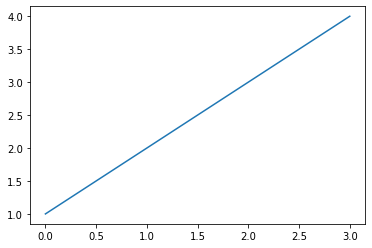